In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta as td
from datetime import date
import datetime as dt
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from itertools import groupby

In [2]:
name = 'swipetimes-2021.01.01-2021.08.20-1.csv'
data = pd.read_csv(name, delimiter=';')
f_name, _ = os.path.splitext(name)
start = pd.to_datetime(f_name[11:21]).date()
finish = pd.to_datetime(f_name[22:32]).date()
del data['Unnamed: 12']

In [3]:
# raw data
data.tail(2)

,Project,Task,Note,Start date & time,End date & time,Start date,Start time,End date,End time,Duration,Duration in hours,Tags
13444,Развлечения,Интернет,NaN,20 авг. 2021 г. 22:41:58,20 авг. 2021 г. 23:10:10,20 авг. 2021 г.,22:41:58,20 авг. 2021 г.,23:10:10,0:28,"0,47",NaN
13445,Сон,NaN,NaN,20 авг. 2021 г. 23:10:10,21 авг. 2021 г. 05:26:37,20 авг. 2021 г.,23:10:10,21 авг. 2021 г.,05:26:37,6:16,"6,27",NaN


## Data prep

In [4]:
# changing 'Duration in hours' field type from str to float
f = lambda x: x.replace(',', '.')
data['Duration in hours'] = data['Duration in hours'].apply(f)
data['Duration in hours'] = data['Duration in hours'].astype(float)

In [5]:
# changing srting to datetime
def date_format(date: str):
    months = {'янв.': '01', 'февр.': '02', 'мар.': '03', 'апр.': '04', 'мая': '05', 'июн.': '06', 'июл.': '07',
              'авг.': '08', 'сент.': '09', 'окт.': '10', 'нояб.': '11', 'дек.': '12'}
    new_date = []
    date = date.split()
    new_date.append(date[2])
    new_date.append(months[date[1]])
    if int(date[0]) < 10:
        new_date.append('0'+date[0])
    else:
        new_date.append(date[0])
    return '-'.join(new_date)+ ' ' + date[4]

In [6]:
# changing srting to date
def date_format2(date: str):
    months = {'янв.': '01', 'февр.': '02', 'мар.': '03', 'апр.': '04', 'мая': '05', 'июн.': '06', 'июл.': '07',
              'авг.': '08', 'сент.': '09', 'окт.': '10', 'нояб.': '11', 'дек.': '12'}
    new_date = []
    date = date.split()
    new_date.append(date[2])
    new_date.append(months[date[1]])
    if int(date[0]) < 10:
        new_date.append('0'+date[0])
    else:
        new_date.append(date[0])
    return pd.to_datetime('-'.join(new_date)).date()

In [7]:
# new fields in datetime and date format
data['Start date & time (date format)'] = data['Start date & time'].apply(date_format)
data['Start date & time (date format)'] = pd.to_datetime(data['Start date & time (date format)'])
data['Start date (date format)'] = data['Start date'].apply(date_format2)

data['End date & time (date format)'] = data['End date & time'].apply(date_format)
data['End date & time (date format)'] = pd.to_datetime(data['End date & time (date format)'])
data['End date (date format)'] = data['End date'].apply(date_format2)

In [8]:
# deleting obsolete fields
del data['Note']
del data['Start date & time']
del data['End date & time']
del data['Start time']
del data['End date']
del data['End time']
del data['Duration']
del data['Start date']

In [9]:
# formatted data
data.head(3)

,Project,Task,Duration in hours,Tags,Start date & time (date format),Start date (date format),End date & time (date format),End date (date format)
0,Развитие,Расслабление,24.00,NaN,2020-07-13 13:59:09,2020-07-13,2020-07-14 13:59:09,2020-07-14
1,Прочее,Сборы,24.00,NaN,2020-09-17 22:33:01,2020-09-17,2020-09-18 22:33:01,2020-09-18
2,Здоровье,Еда,0.92,NaN,2020-12-31 23:28:04,2020-12-31,2021-01-01 00:23:02,2021-01-01


In [10]:
# entries, moving to the next date
change_data = data[data['Start date (date format)'] != data['End date (date format)']]
change_data.tail(3)

,Project,Task,Duration in hours,Tags,Start date & time (date format),Start date (date format),End date & time (date format),End date (date format)
13345,Сон,NaN,7.14,NaN,2021-08-18 23:41:19,2021-08-18,2021-08-19 06:49:58,2021-08-19
13406,Сон,NaN,7.31,NaN,2021-08-19 23:42:08,2021-08-19,2021-08-20 07:00:49,2021-08-20
13445,Сон,NaN,6.27,NaN,2021-08-20 23:10:10,2021-08-20,2021-08-21 05:26:37,2021-08-21


In [11]:
# breaking entries, that are moving to the next date, to 2 entries for each date and saving them to con

con = []
for label, row in change_data.iterrows():
    duration_1 = pd.to_datetime(row['End date (date format)']) - row['Start date & time (date format)'] - td(seconds=1)
    duration_2 = row['End date & time (date format)'] - pd.to_datetime(row['End date (date format)'])
    end_date_1 = row['Start date & time (date format)'] + duration_1
    end_date_1_1 = end_date_1.date()
    start_date_2 = row['End date & time (date format)'] - duration_2
    start_date_2_1 = start_date_2.date()
     
    a = {
        'Project': row['Project'],
        'Task': row['Task'],
        'Duration in hours': float("{:2.2f}".format(duration_1.seconds /3600)),
        'Tags': row['Tags'],
        'Start date & time (date format)': row['Start date & time (date format)'],
        'Start date (date format)': row['Start date (date format)'],
        'End date & time (date format)': end_date_1,
        'End date (date format)': end_date_1_1
    }
    
    b = {
        'Project': row['Project'],
        'Task': row['Task'],
        'Duration in hours': float("{:2.2f}".format(duration_2.seconds /3600)),
        'Tags': row['Tags'],
        'Start date & time (date format)': start_date_2,
        'Start date (date format)': start_date_2_1,
        'End date & time (date format)': row['End date & time (date format)'],
        'End date (date format)': row['End date (date format)']
    }    
    
    con.append(a)
    con.append(b)

In [12]:
# con list to dataframe
con = pd.DataFrame.from_dict(con)
con.head(7)

,Project,Task,Duration in hours,Tags,Start date & time (date format),Start date (date format),End date & time (date format),End date (date format)
0,Развитие,Расслабление,10.01,NaN,2020-07-13 13:59:09,2020-07-13,2020-07-13 23:59:59,2020-07-13
1,Развитие,Расслабление,13.99,NaN,2020-07-14 00:00:00,2020-07-14,2020-07-14 13:59:09,2020-07-14
2,Прочее,Сборы,1.45,NaN,2020-09-17 22:33:01,2020-09-17,2020-09-17 23:59:59,2020-09-17
3,Прочее,Сборы,22.55,NaN,2020-09-18 00:00:00,2020-09-18,2020-09-18 22:33:01,2020-09-18
4,Здоровье,Еда,0.53,NaN,2020-12-31 23:28:04,2020-12-31,2020-12-31 23:59:59,2020-12-31
5,Здоровье,Еда,0.38,NaN,2021-01-01 00:00:00,2021-01-01,2021-01-01 00:23:02,2021-01-01
6,Прочее,Сборы,0.12,NaN,2021-01-01 23:52:50,2021-01-01,2021-01-01 23:59:59,2021-01-01


In [13]:
# merging the main dataframe with con
new_merge = pd.concat([data, con])
# sorting by date and deleting entries, moving to the next date
new_merge = new_merge[new_merge['Start date (date format)'] == new_merge['End date (date format)']]
new_merge = new_merge.sort_values(by='Start date & time (date format)', ignore_index=True)
# deleting strange extra early entries
new_merge = new_merge[new_merge['Start date (date format)'] >= start][:-1]
# filling Task field for Sleep (otherwise it's null)
new_merge['Task'] = new_merge['Task'].fillna('Сон')

In [14]:
# checking the beginning
new_merge.head(3)

,Project,Task,Duration in hours,Tags,Start date & time (date format),Start date (date format),End date & time (date format),End date (date format)
5,Здоровье,Еда,0.38,NaN,2021-01-01 00:00:00,2021-01-01,2021-01-01 00:23:02,2021-01-01
6,Прочее,Сборы,0.20,NaN,2021-01-01 00:23:02,2021-01-01,2021-01-01 00:35:08,2021-01-01
7,Общение,Друзья,0.93,NaN,2021-01-01 00:35:08,2021-01-01,2021-01-01 01:30:48,2021-01-01


In [15]:
# checking the end
new_merge.tail(3)

,Project,Task,Duration in hours,Tags,Start date & time (date format),Start date (date format),End date & time (date format),End date (date format)
13665,Здоровье,Гигиена,0.23,NaN,2021-08-20 22:27:55,2021-08-20,2021-08-20 22:41:58,2021-08-20
13666,Развлечения,Интернет,0.47,NaN,2021-08-20 22:41:58,2021-08-20,2021-08-20 23:10:10,2021-08-20
13667,Сон,Сон,0.83,NaN,2021-08-20 23:10:10,2021-08-20,2021-08-20 23:59:59,2021-08-20


## Daliy graphs data prep

In [16]:
# first date in daily graphs
finish - td(days = 30)

datetime.date(2021, 7, 21)

In [17]:
# last 30 days dataframe
daily = new_merge[new_merge['End date (date format)'] >= (finish - td(days = 30))]
daily.head(3)

,Project,Task,Duration in hours,Tags,Start date & time (date format),Start date (date format),End date & time (date format),End date (date format)
12027,Сон,Сон,6.10,NaN,2021-07-21 00:00:00,2021-07-21,2021-07-21 06:06:00,2021-07-21
12028,Развлечения,Интернет,0.08,NaN,2021-07-21 06:06:00,2021-07-21,2021-07-21 06:10:52,2021-07-21
12029,Развитие,Расслабление,0.06,NaN,2021-07-21 06:10:52,2021-07-21,2021-07-21 06:14:41,2021-07-21


In [18]:
# sum 'Duration in hours' by Start date and Project
daily_pivot = pd.pivot_table(daily, columns='Project', values='Duration in hours', aggfunc=np.sum,
                            index='Start date (date format)', fill_value=0)
daily_pivot_norm = daily_pivot
daily_pivot_norm.tail(3)

Project,Здоровье,Общение,Продуктивность,Прочее,Развитие,Развлечения,Сон,Уход за семьей,Учёба
Start date (date format),,,,,,,,,
2021-08-18,0.89,1.44,6.13,0.10,0.00,5.76,7.32,2.37,0.0
2021-08-19,1.46,0.63,7.05,0.34,0.29,5.06,7.13,2.03,0.0
2021-08-20,1.57,0.71,7.54,0.08,0.09,4.82,7.84,1.32,0.0


In [19]:
# homekeeping tasks duration by type for the last 30 days
home_30 = daily[daily['Project'] == 'Уход за семьей'].groupby('Task').sum().sort_values(by='Duration in hours',
                                                                                        ascending=False)
home_30

,Duration in hours
Task,
Организация,23.29
Готовка,12.09
Уборка / стирка,9.79
Магазин (и интернет-шопинг),6.70
Кошка,3.37
Финансы,0.28


In [21]:
# making daily datasets for types of activity:
# study, self-improvement

study_by_day = pd.pivot_table(daily[daily['Project'] == 'Учёба'], columns='Project',
                              values='Duration in hours', aggfunc=np.sum, index='Start date (date format)', fill_value=0)
for x in daily_pivot_norm.index:
    if x not in study_by_day.index:
        new_row = pd.Series(data={'Учёба': 0.0}, name=x)
        study_by_day = study_by_day.append(new_row, ignore_index=False)
study_by_day = study_by_day.sort_index()

improvement_by_day = pd.pivot_table(daily[daily['Project'] == 'Развитие'], columns='Project', values='Duration in hours',
                                    aggfunc=np.sum, index='Start date (date format)', fill_value=0)
improvement_by_day = improvement_by_day[1:]
for x in daily_pivot_norm.index:
    if x not in improvement_by_day.index:
        new_row = pd.Series(data={'Развитие': 0.0}, name=x)
        improvement_by_day = improvement_by_day.append(new_row, ignore_index=False)
improvement_by_day = improvement_by_day.sort_index()

In [22]:
# all physical activities daily

fiz = daily[daily['Task'] == 'Физическая активность']
fiz = fiz.fillna('Другое')
fiz_by_day = pd.pivot_table(fiz, columns=['Tags'], values='Duration in hours', aggfunc=np.sum,
                            index='Start date (date format)', fill_value=0)
for x in daily_pivot_norm.index:
    if x not in fiz_by_day.index:
        new_row = pd.Series(data={'Другое': 0.0, 'Йога': 0.0, 'Фитнес': 0.0}, name=x)
        fiz_by_day = fiz_by_day.append(new_row, ignore_index=False)
fiz_by_day = fiz_by_day.sort_index()
fiz_by_day['Физическая активность'] = fiz_by_day.sum(axis=1)

## Weekly graphs data

In [23]:
# aggregating projects by day
data_pivot = pd.pivot_table(new_merge, columns='Project', values='Duration in hours', aggfunc=np.sum,
                            index='Start date (date format)', fill_value=0)
data_pivot.head(2)

Project,Здоровье,Общение,Продуктивность,Прочее,Развитие,Развлечения,Сон,Уход за семьей,Учёба
Start date (date format),,,,,,,,,
2021-01-01,3.04,1.98,0.00,0.65,0.86,8.45,7.26,1.74,0.0
2021-01-02,2.03,0.91,0.04,0.29,0.09,10.67,7.25,2.69,0.0


In [24]:
# aggregating projects by week
data_pivot_by_week = data_pivot.copy()
data_pivot_by_week['Start date (date format)'] = pd.to_datetime(data_pivot_by_week.index)
data_pivot_by_week = data_pivot_by_week.groupby([pd.Grouper(key='Start date (date format)', freq='W-SUN')]).sum()
data_pivot_by_week.head(2)

Project,Здоровье,Общение,Продуктивность,Прочее,Развитие,Развлечения,Сон,Уход за семьей,Учёба
Start date (date format),,,,,,,,,
2021-01-03,6.20,7.62,0.11,3.44,2.23,22.76,22.97,6.58,0.0
2021-01-10,13.71,25.76,0.25,7.93,5.13,49.38,56.01,6.90,3.0


In [25]:
# double of "aggregating projects by week" dataset, but with relative values
dpn_total = 0
for column in data_pivot_by_week.columns:
    dpn_total += data_pivot_by_week[column]
dpn_rel = data_pivot_by_week[data_pivot_by_week.columns].div(dpn_total, 0)
dpn_rel.head(2)

Project,Здоровье,Общение,Продуктивность,Прочее,Развитие,Развлечения,Сон,Уход за семьей,Учёба
Start date (date format),,,,,,,,,
2021-01-03,0.086219,0.105966,0.001530,0.047838,0.031011,0.316507,0.319427,0.091503,0.00000
2021-01-10,0.081573,0.153269,0.001487,0.047183,0.030523,0.293806,0.333254,0.041054,0.01785


In [26]:
# aggregating tasks by day
task_pivot = pd.pivot_table(new_merge, columns=['Project', 'Task'], values='Duration in hours', aggfunc=np.sum,
                            index='Start date (date format)', fill_value=0)
task_pivot.head(2)

Project                  Здоровье                                             \
Task                        Врачи Гигиена   Еда Массаж Физическая активность   
Start date (date format)                                                       
2021-01-01                    0.0    1.84  1.20    0.0                   0.0   
2021-01-02                    0.0    1.27  0.76    0.0                   0.0   

Project                  Общение                                   ...  \
Task                      Друзья Животные Коллеги Парень Свидание  ...   
Start date (date format)                                           ...   
2021-01-01                  1.01     0.51     0.0    0.0      0.0  ...   
2021-01-02                  0.05     0.38     0.0    0.0      0.0  ...   

Project                  Уход за семьей                              \
Task                              Кошка Магазин (и интернет-шопинг)   
Start date (date format)                                              
2021-01-01                          0.0                         0.0   
2021-01-02                          0.0                         0.0   

Project                                                              \
Task                     Организация Письма Уборка / стирка Финансы   
Start date (date format)                                              
2021-01-01                      0.79    0.0            0.67     0.0   
2021-01-02                      1.20    0.0            0.77     0.0   

Project                         Учёба                                   
Task                     Data science  ИзИ Математика Программирование  
Start date (date format)                                                
2021-01-01                        0.0  0.0        0.0              0.0  
2021-01-02                        0.0  0.0        0.0              0.0  

[2 rows x 46 columns]

In [27]:
# aggregating tasks by week
task_pivot_by_week = task_pivot.copy()
task_pivot_by_week['Start date (date format)'] = pd.to_datetime(task_pivot_by_week.index)
task_pivot_by_week = task_pivot_by_week.groupby([pd.Grouper(key='Start date (date format)', freq='W-SUN')]).sum()
task_pivot_by_week.head(2)

Project                  Здоровье                                             \
Task                        Врачи Гигиена   Еда Массаж Физическая активность   
Start date (date format)                                                       
2021-01-03                    0.0    3.37  2.61    0.0                  0.22   
2021-01-10                    0.0    4.52  4.77    0.0                  4.42   

Project                  Общение                                   ...  \
Task                      Друзья Животные Коллеги Парень Свидание  ...   
Start date (date format)                                           ...   
2021-01-03                  2.80     0.96     0.0    0.0     2.67  ...   
2021-01-10                  2.51     2.20     0.0    0.0    12.12  ...   

Project                  Уход за семьей                              \
Task                              Кошка Магазин (и интернет-шопинг)   
Start date (date format)                                              
2021-01-03                         0.00                        0.71   
2021-01-10                         0.61                        0.61   

Project                                                              \
Task                     Организация Письма Уборка / стирка Финансы   
Start date (date format)                                              
2021-01-03                      2.70    0.0            1.63     0.0   
2021-01-10                      1.34    0.0            1.73     0.0   

Project                         Учёба                                   
Task                     Data science  ИзИ Математика Программирование  
Start date (date format)                                                
2021-01-03                        0.0  0.0        0.0              0.0  
2021-01-10                        3.0  0.0        0.0              0.0  

[2 rows x 46 columns]

In [29]:
# all physical activities weekly
exercise = new_merge[new_merge['Task'] == 'Физическая активность']
exercise = exercise.fillna('Другое')
exercise = pd.pivot_table(exercise, columns='Tags', values='Duration in hours', aggfunc=np.sum,
                            index='Start date (date format)', fill_value=0)
exercise['Start date (date format)'] = pd.to_datetime(exercise.index)
exercise = exercise.groupby([pd.Grouper(key='Start date (date format)', freq='W-SUN')]).sum()
exercise['all_except_fy'] = exercise[exercise.columns.drop(['Йога', 'Фитнес'])].sum(axis=1)
exercise.head(2)

Tags,Другое,Йога,Мама|Прогулка,Прогулка,Уход за кожей и/или волосами,Фитнес,all_except_fy
Start date (date format),,,,,,,
2021-01-03,0.22,0.00,0.00,0.0,0.0,0.00,0.22
2021-01-10,1.19,1.46,0.81,0.0,0.0,0.96,2.00


In [34]:
# functions for dates labels

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.04
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[0::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

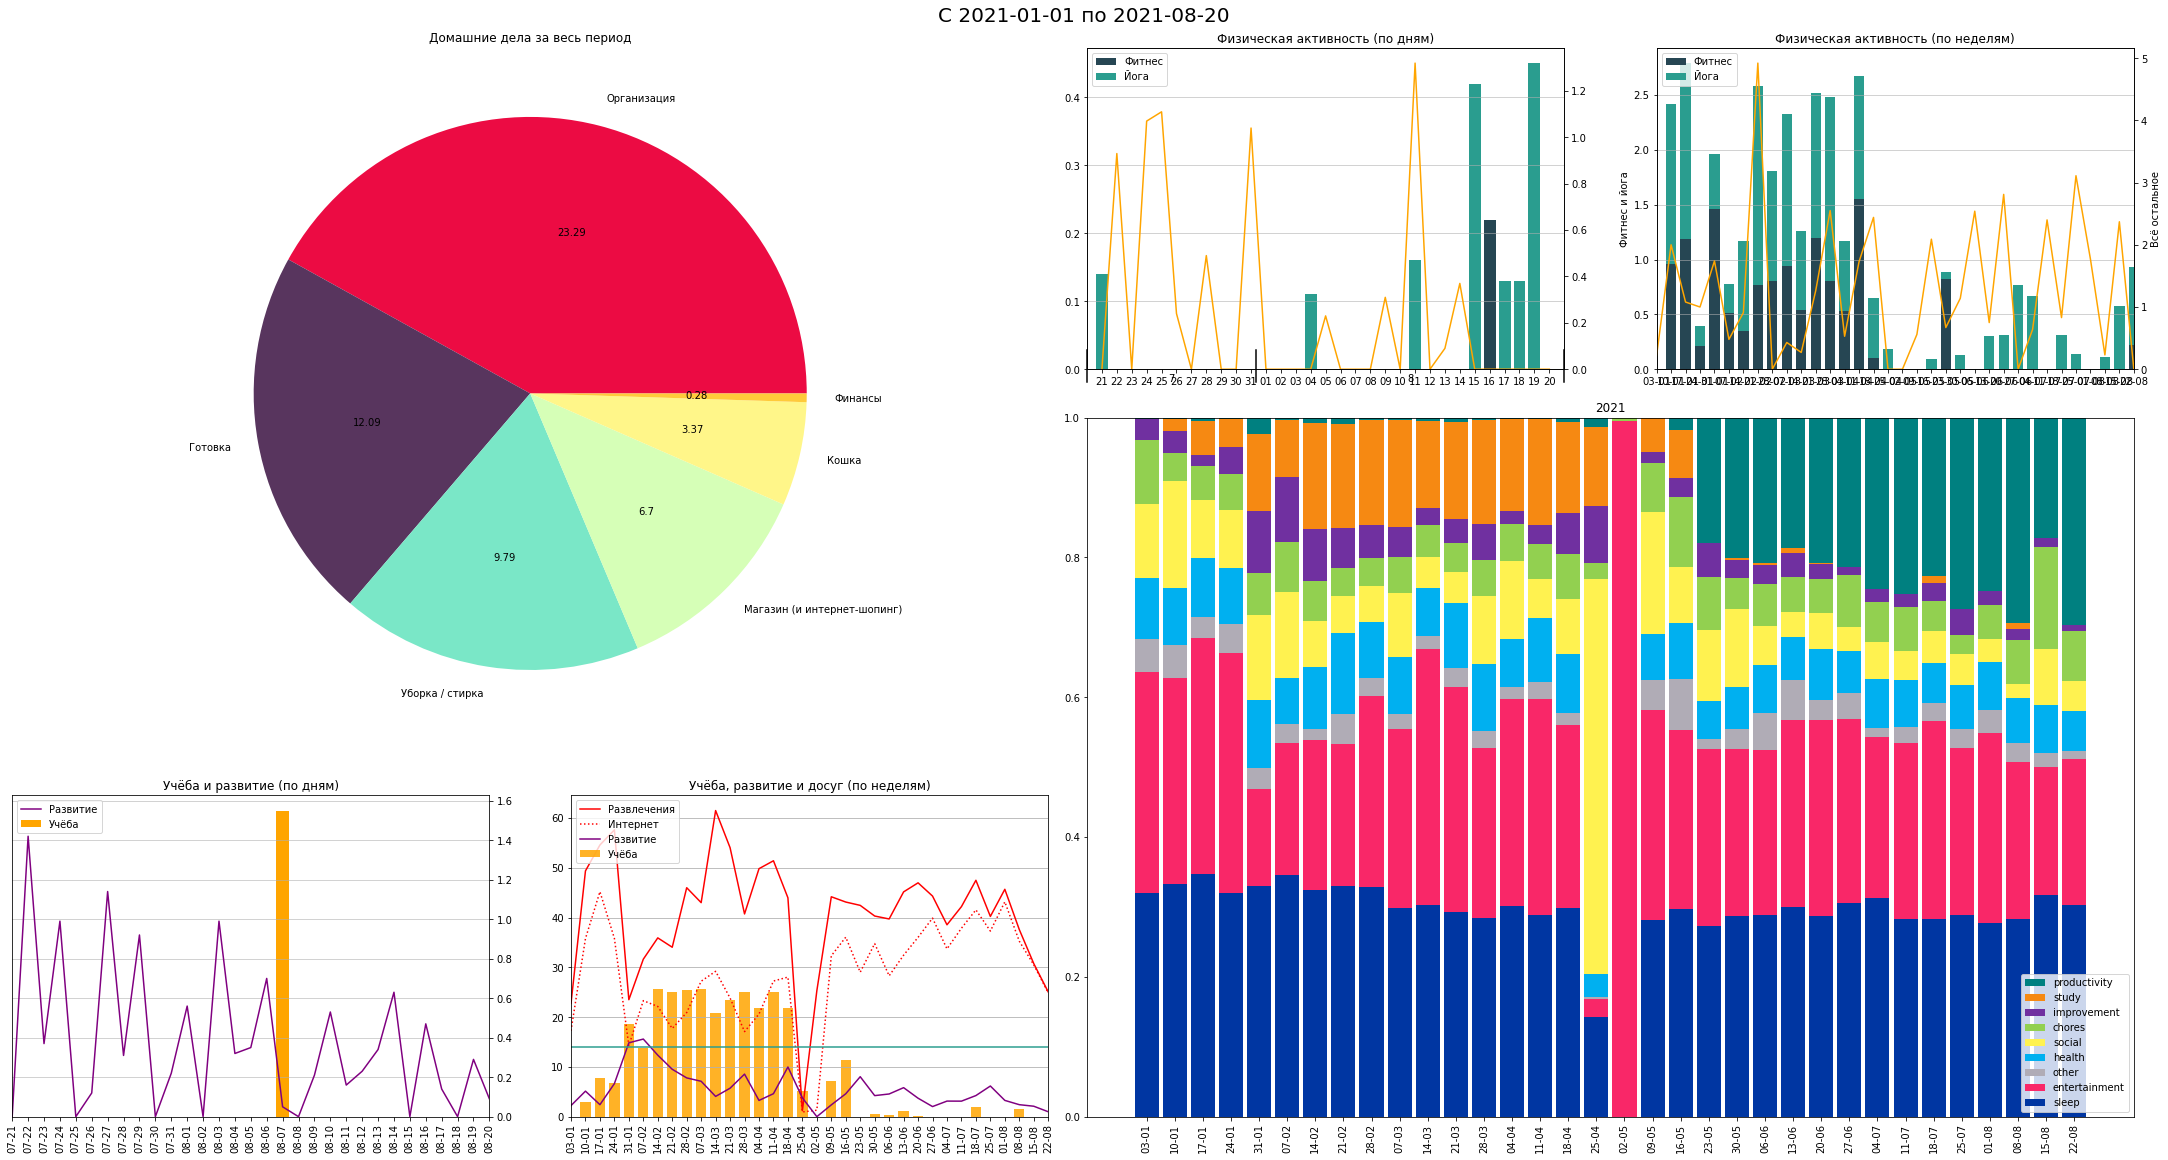

In [45]:
# DAILY GRAPHS FOR THE LAST 30 DAYS

fg = plt.figure(figsize=(30,16), constrained_layout=True)
gs = fg.add_gridspec(3, 4)
w = 6
x1 = daily_pivot_norm.index
x2 = dpn_rel.index
# getting month numbers
m = pd.to_datetime(x1).strftime('%m').unique().astype(int)
l_1 = pd.to_datetime(x1).month
xticks = pd.to_datetime(x1).strftime('%d')
# super-index for multilayered ticks
super_index = pd.MultiIndex.from_frame(pd.DataFrame(zip(l_1, xticks), columns=['Months', 'Dates']))
d_super_index = pd.DataFrame([0]*len(super_index), index=super_index)



# homekeeping from start date to finish date
fig_ax_0 = fg.add_subplot(gs[:2, :2])
def absolute_value2(val):
    a  = home_30['Duration in hours'].values[ np.abs(home_30['Duration in hours'].values - val/100.*home_30['Duration in hours'].values.sum()).argmin() ]
    return round(a, 2)
pie_color = ['#EC0B43', '#58355E', '#7AE7C7', '#D6FFB7', '#FFF689', '#FFCA3A']
fig_ax_0.pie(home_30['Duration in hours'].values, labels = home_30.index, autopct=absolute_value2, colors=pie_color)


# study and self-improvement
fig_ax_1 = fg.add_subplot(gs[2, 0])
fig_ax_1.plot(
    x1,
    improvement_by_day['Развитие'], 'purple')
fig_ax_1.bar(x1, study_by_day['Учёба'], color='orange')
plt.legend(['Развитие', 'Учёба'], loc=2)
fig_ax_1.yaxis.tick_right()
fig_ax_1.grid(axis='y', alpha=0.7)
plt.xlim(x1[0], x1[-1])
plt.ylim(0)
plt.xticks(x1, labels=pd.to_datetime(x1).strftime('%m-%d'), rotation='vertical')

# physical activities
fig_ax_2 = fg.add_subplot(gs[0, 2])
fig_ax_2.bar(x1, fiz_by_day['Фитнес'],  label='Фитнес', color='#264653')
fig_ax_2.bar(x1, fiz_by_day['Йога'], label='Йога', color='#2a9d8f',
       bottom=np.array(fiz_by_day['Фитнес']))
fig_ax_2_1 = fig_ax_2.twinx()
fig_ax_2_1.plot(x1, fiz_by_day['Другое'], label='Другое', color='orange')

fig_ax_2.legend(loc=2)
fig_ax_2.grid(axis='y', alpha=0.7)
# fig_ax_2.set(facecolor ='#e9c46a')
plt.xlim(x1[0]-pd.Timedelta(days=1), x1[-1]+pd.Timedelta(days=1))
plt.ylim(0)
plt.xticks(x1, labels=pd.to_datetime(x1).strftime('%d'))
label_group_bar_table(fig_ax_2, d_super_index)



# WEEKLY GRAPHS

# all together
fig_ax_3 = fg.add_subplot(gs[1:, 2:])
# plt.figure(figsize=(15, 5))
plt.bar(x2, dpn_rel['Сон'],  label='sleep', color='#0036A2', width=w)
plt.bar(x2, dpn_rel['Развлечения'], label='entertainment', color='#F92768', width=w,
       bottom=np.array(dpn_rel['Сон']))
plt.bar(x2, dpn_rel['Прочее'], label='other', color='#B0ACB6', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения']))
plt.bar(x2, dpn_rel['Здоровье'], label='health', color='#00B0F0', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения'])+
            np.array(dpn_rel['Прочее']))
plt.bar(x2, dpn_rel['Общение'], label='social', color='#FFF250', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения'])+
            np.array(dpn_rel['Прочее'])+
            np.array(dpn_rel['Здоровье']))
plt.bar(x2, dpn_rel['Уход за семьей'], label='chores', color='#92D050', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения'])+
            np.array(dpn_rel['Прочее'])+
            np.array(dpn_rel['Здоровье'])+
            np.array(dpn_rel['Общение']))
plt.bar(x2, dpn_rel['Развитие'], label='improvement',color='#7030A0', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения'])+
            np.array(dpn_rel['Прочее'])+
            np.array(dpn_rel['Здоровье'])+
            np.array(dpn_rel['Общение'])+
            np.array(dpn_rel['Уход за семьей']))
plt.bar(x2, dpn_rel['Учёба'], label='study', color='#F68912', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения'])+
            np.array(dpn_rel['Прочее'])+
            np.array(dpn_rel['Здоровье'])+
            np.array(dpn_rel['Общение'])+
            np.array(dpn_rel['Уход за семьей'])+
            np.array(dpn_rel['Развитие']))
plt.bar(x2, dpn_rel['Продуктивность'], label='productivity', color='#008080', width=w,
       bottom=np.array(dpn_rel['Сон'])+
            np.array(dpn_rel['Развлечения'])+
            np.array(dpn_rel['Прочее'])+
            np.array(dpn_rel['Здоровье'])+
            np.array(dpn_rel['Общение'])+
            np.array(dpn_rel['Уход за семьей'])+
            np.array(dpn_rel['Развитие'])+
            np.array(dpn_rel['Учёба']))
plt.xticks(x2, labels=pd.to_datetime(x2).strftime('%d-%m'), rotation='vertical')
handles, labels = plt.gca().get_legend_handles_labels()
order = [8,7,6,5,4,3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4)

w2 = 5
# Study and entertainment
fig_ax_5 = fg.add_subplot(gs[2, 1])
plt.plot(x2,
         task_pivot_by_week['Развлечения'].sum(axis=1), 'r',
         task_pivot_by_week['Развлечения']['Интернет'], 'r:',
#          study_by_week['Duration in hours'], 'orange',
         task_pivot_by_week['Развитие'].sum(axis=1), 'purple')
plt.bar(x2, task_pivot_by_week['Учёба'].sum(axis=1), width=w2, alpha=0.85, color='orange')
plt.legend(['Развлечения', 'Интернет', 'Развитие', 'Учёба'], loc=2)
plt.xticks(x2, labels=pd.to_datetime(x2).strftime('%d-%m'), rotation='vertical')
plt.xlim(x2[0], x2[-1])
plt.ylim(0)
plt.grid(axis='y')
plt.axhline(14, color='#2a9d8f')

# excercise 2
fig_ax_4 = fg.add_subplot(gs[0, 3])
fig_ax_4.bar(x2, exercise['Фитнес'],  label='Фитнес', color='#264653', width=w2)
fig_ax_4.bar(x2, exercise['Йога'], label='Йога', color='#2a9d8f',
       bottom=np.array(exercise['Фитнес']), width=w2)
fig_ax_4_1 = fig_ax_4.twinx()
fig_ax_4_1.plot(x2, exercise['all_except_fy'], label='Всё остальное', color='orange')

fig_ax_4.legend(loc=2)
fig_ax_4.grid(axis='y', alpha=0.7)
plt.ylim(0)
plt.xticks(x2, labels=pd.to_datetime(x2).strftime('%d-%m'), rotation='vertical')
fig_ax_4.set_ylabel('Фитнес и йога')
fig_ax_4_1.set_ylabel('Всё остальное')
plt.xlim(x2[0], x2[-1])



# headers
plt.suptitle(f'С {start} по {finish}', size=20)
fig_ax_0.set_title('Домашние дела за весь период')

# fig_ax_1 = fg.add_subplot(gs[2, 0])
fig_ax_1.set_title('Учёба и развитие (по дням)')
# fig_ax_5 = fg.add_subplot(gs[2, 1])
fig_ax_5.set_title('Учёба, развитие и досуг (по неделям)')

# fig_ax_2 = fg.add_subplot(gs[0, 2])
fig_ax_2.set_title('Физическая активность (по дням)')
# fig_ax_4 = fg.add_subplot(gs[0, 3])
fig_ax_4.set_title('Физическая активность (по неделям)')
# fig_ax_3 = fg.add_subplot(gs[1:, 2:])
fig_ax_3.set_title('2021')

# saving the result like a picture
# plt.savefig(f'{start}--{finish} общ.jpeg')
plt.show()